# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [1]:
import random
import pandas as pd
import numpy as np

import holidays

from meteostat import Point, Daily

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.signal import periodogram

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Configuration

In [ ]:
# How many (lagged) days to use as input during training
historical_window_size = 3
# How many days to teach the model to predict 
prediction_window_size = 3
# How many predictions to do as part of recursive forecasting
num_of_predictions = 1

## Prepare data

### Load data

In [3]:
aqi_pd = pd.read_csv("../data/air_quality_history.csv", skipinitialspace=True)

In [4]:
# Make sure column names are stripped
aqi_pd.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [5]:
aqi_pd["date"] = pd.to_datetime(aqi_pd["date"], format="%Y/%m/%d")

In [6]:
aqi_pd = aqi_pd.set_index("date")

In [7]:
aqi_pd.head()

,pm25,pm10,no2,so2,co
date,,,,,
2025-07-01,28.0,12.0,3.0,1.0,5.0
2025-07-02,41.0,22.0,7.0,1.0,5.0
2025-07-03,65.0,16.0,3.0,NaN,5.0
2025-07-04,42.0,12.0,3.0,1.0,5.0
2025-07-05,41.0,14.0,2.0,1.0,5.0


In [8]:
aqi_pd.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1297.000000,1298.000000,1289.000000,1203.000000,1291.000000
mean,44.872783,15.106317,5.600465,3.142145,3.977537
std,18.256785,7.781882,3.761653,1.699734,1.555273
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,44.000000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [9]:
full_range = pd.date_range(start=aqi_pd.index.min(), end=aqi_pd.index.max(), freq="D")

# Check for missing dates
full_range.difference(aqi_pd.index)

DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')

In [10]:
aqi_pd.loc[pd.Timestamp("2024-12-30")] = aqi_pd.loc[pd.Timestamp("2024-12-31")]
aqi_pd = aqi_pd.sort_index()

In [11]:
full_range.difference(aqi_pd.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### Handle N/A values

In [12]:
aqi_pd.isna().sum()

pm25     3
pm10     1
no2     10
so2     96
co       8
dtype: int64

In [13]:
aqi_pd = aqi_pd.fillna(aqi_pd.median())

In [14]:
aqi_pd.isna().sum()

pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64

## Feature engineering

### Calendar Features

In [15]:
svk_holidays = holidays.Slovakia()

datetime_pd = aqi_pd.index

aqi_pd["year"] = datetime_pd.year
aqi_pd["month"] = datetime_pd.month
aqi_pd["day_of_month"] = datetime_pd.day
aqi_pd["day_of_week"] = datetime_pd.dayofweek
aqi_pd["day_of_year"] = datetime_pd.dayofyear
aqi_pd["week_of_year"] = datetime_pd.isocalendar().week
aqi_pd["is_leap_year"] = datetime_pd.is_leap_year.astype(int)
aqi_pd["is_working_day"] = [int(svk_holidays.is_working_day(x)) for x in datetime_pd]
aqi_pd["is_feb29"] = ((aqi_pd["month"] == 2) & (aqi_pd["day_of_month"] == 29)).astype(int)

### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [16]:
# Define Poprad coordinates
# Coordinates of Poprad-Tatry Airport (LZTT) meteo station.
location = Point(49.07, 20.24, 718)  # Lat, Lon, Elevation (optional but good)

start_date = datetime_pd.min()
end_date = datetime_pd.max()

daily_weather = Daily(location, start_date, end_date)
weather_pd = daily_weather.fetch()

print(weather_pd.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2021-12-27 -13.1 -17.2  -8.0  <NA>  <NA>  <NA>   2.7  13.0  1009.1  <NA>
2021-12-28  -9.3 -13.8  -2.0  <NA>  <NA>  <NA>   4.0  13.0  1006.6  <NA>
2021-12-29  -4.1  -8.1  -0.9  <NA>  <NA>  <NA>   4.8  14.8  1005.6  <NA>
2021-12-30  -3.6  -9.6   1.8  <NA>  <NA>  <NA>   4.7  13.0  1015.0  <NA>
2021-12-31   3.9  -0.2   8.2  <NA>  <NA>  <NA>  15.2  33.3  1017.1  <NA>


In [17]:
weather_pd.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,1300.0,1300.0,1300.0,1165.0,4.0,0.0,1300.0,1289.0,1300.0,0.0
mean,7.847923,2.567154,13.119231,2.114764,2.0,<NA>,12.482077,26.591777,1016.236,<NA>
std,7.977937,7.356673,9.118355,4.390847,1.414214,<NA>,6.636817,9.29342,7.995956,<NA>
min,-13.1,-20.2,-8.0,0.0,1.0,<NA>,2.6,11.1,987.5,<NA>
25%,1.175,-3.0,6.0,0.0,1.0,<NA>,7.8,20.4,1011.6,<NA>
50%,7.7,2.9,13.1,0.1,1.5,<NA>,10.5,24.1,1016.8,<NA>
75%,14.6,8.525,20.725,2.1,2.5,<NA>,15.325,31.5,1021.2,<NA>
max,24.5,18.4,34.0,42.7,4.0,<NA>,47.8,57.4,1039.8,<NA>


In [18]:
# No data available for these features from selected meteo station
weather_pd.drop(["wdir", "tsun"], axis=1, inplace=True)

In [19]:
weather_pd.isna().sum()

tavg       0
tmin       0
tmax       0
prcp     135
snow    1296
wspd       0
wpgt      11
pres       0
dtype: int64

In [20]:
# N/A here means that there was no rain or snow - so filling with 0 instead
weather_pd["prcp"] = weather_pd["prcp"].fillna(0.0)
weather_pd["snow"] = weather_pd["snow"].fillna(0.0)

# Let's assume that rest N/A is just missing reading, and fill with median
weather_pd.fillna(weather_pd.median(), inplace=True)

In [21]:
weather_pd.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64

In [22]:
merged_df = pd.merge_asof(aqi_pd, weather_pd, left_index=True, right_index=True)

In [23]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,44.0,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [24]:
merged_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co', 'year', 'month', 'day_of_month',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_leap_year',
       'is_working_day', 'is_feb29', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wspd', 'wpgt', 'pres'],
      dtype='object')

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [25]:
merged_df = merged_df.astype(float)

In [26]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year              float64
month             float64
day_of_month      float64
day_of_week       float64
day_of_year       float64
week_of_year      float64
is_leap_year      float64
is_working_day    float64
is_feb29          float64
tavg              float64
tmin              float64
tmax              float64
prcp              float64
snow              float64
wspd              float64
wpgt              float64
pres              float64
dtype: object

## Explore trends

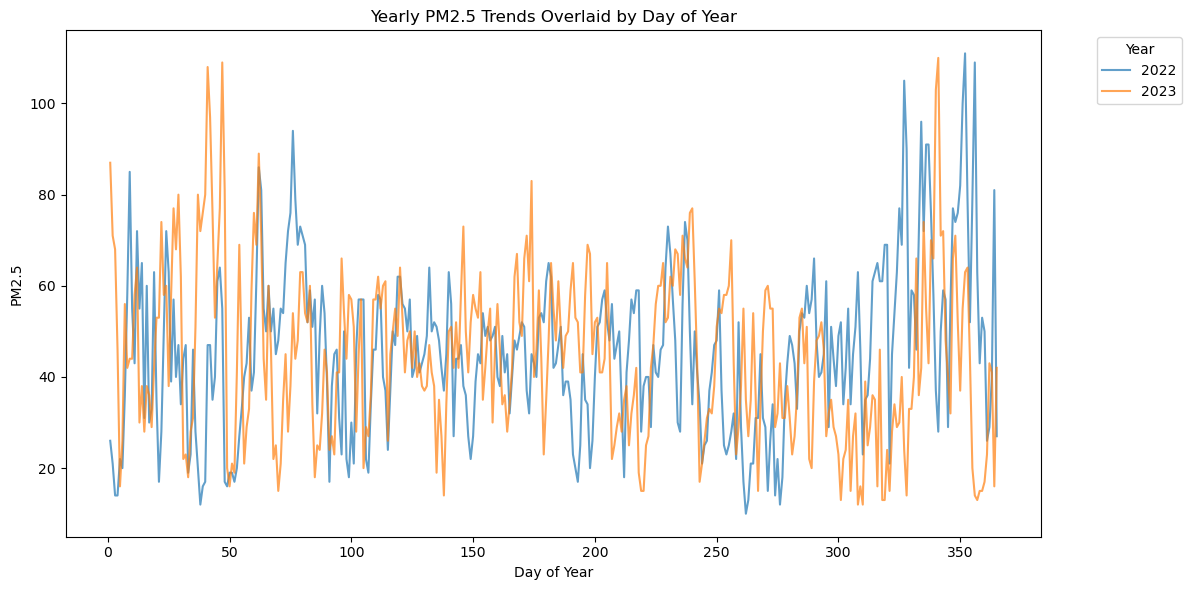

In [27]:
plt.figure(figsize=(12, 6))
for year, group in aqi_pd.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

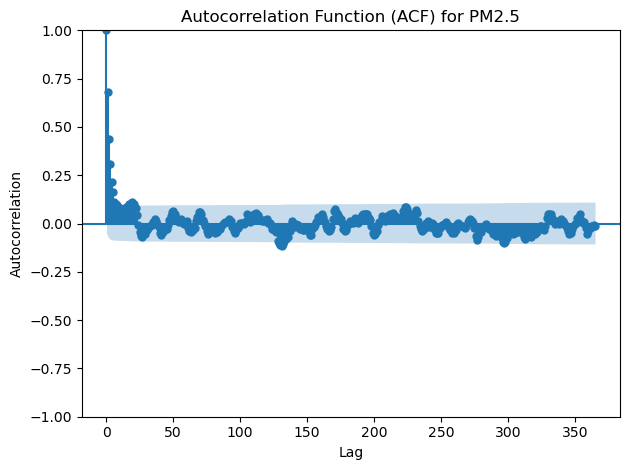

In [28]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_pd["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

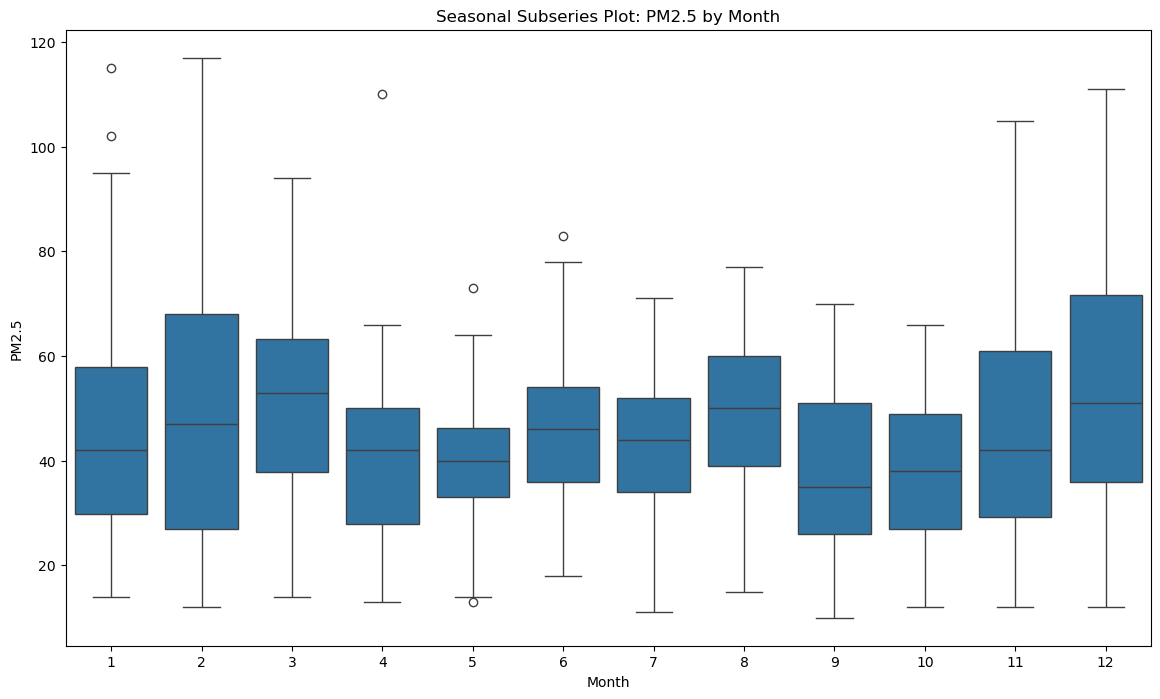

In [29]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_pd)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

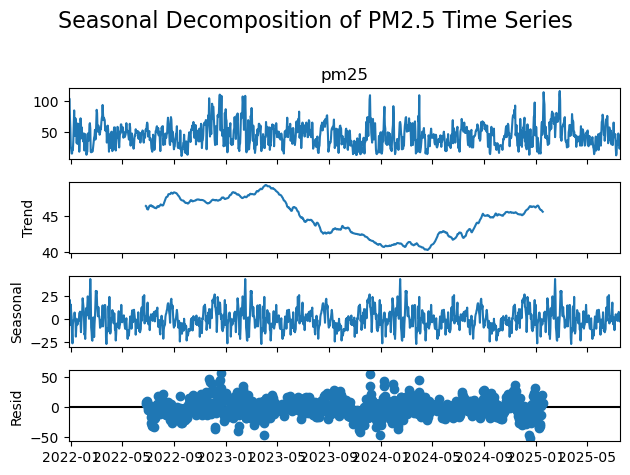

In [30]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_pd["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

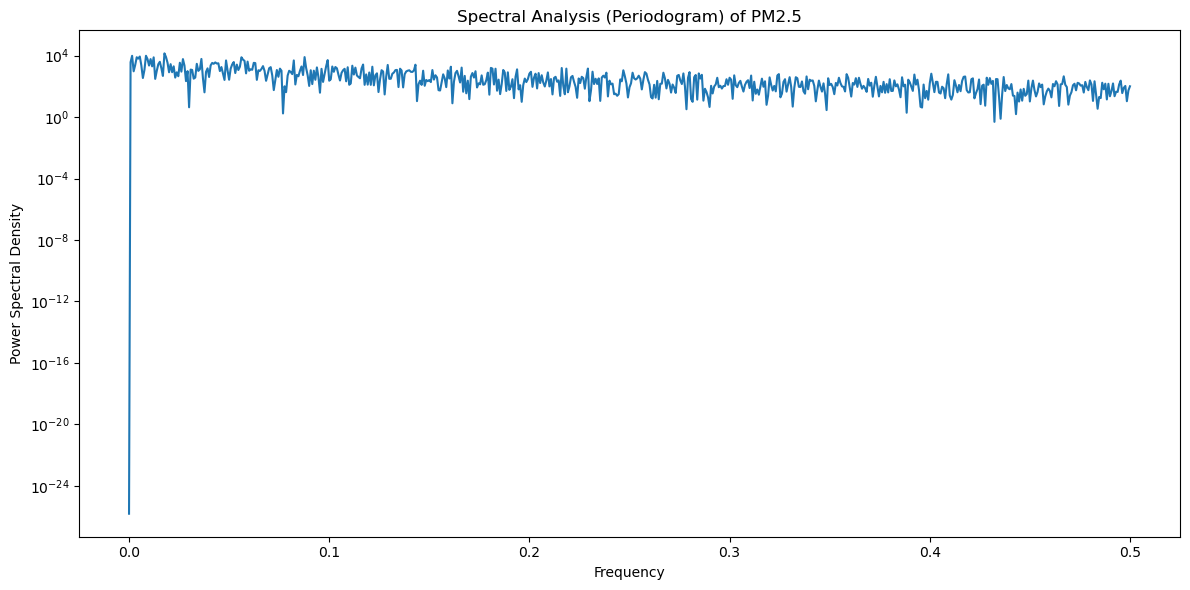

In [31]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_pd["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [32]:
train_size = int(len(merged_df) * 0.8)
val_size = int(len(merged_df) * 0.1)

train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size : train_size + val_size]
test_df = merged_df.iloc[train_size + val_size :]

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [33]:
numerical_features = [
    col
    for col in merged_df.columns
    if col not in ["is_leap_year", "is_feb29", "is_working_day"]
]

scaler = StandardScaler()
# Important: Fit the scaler only on the training data and then transform both training and testing data to prevent data leakage.
scaler = scaler.fit(pd.concat([train_df[numerical_features], val_df[numerical_features]], axis=0))

In [34]:
train_df.loc[:, numerical_features] = scaler.transform(train_df[numerical_features])
val_df.loc[:, numerical_features] = scaler.transform(val_df[numerical_features])
test_df.loc[:, numerical_features] = scaler.transform(test_df[numerical_features])

In [35]:
train_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-0.067252,2.712169,5.004259,-0.671911,5.124271,-2.268147,1.616459,1.281734,-1.497919,1.709603,...,1.0,0.0,-2.546314,-2.606148,-2.246530,-0.462269,-0.044702,-1.440911,-1.419022,-0.875414
2021-12-28,3.211294,2.587238,3.962401,-0.082604,3.234767,-2.268147,1.616459,1.394956,-0.998186,1.718804,...,1.0,0.0,-2.075848,-2.151930,-1.594735,-0.462269,-0.044702,-1.247325,-1.419022,-1.179327
2021-12-29,3.157547,1.337932,2.920542,-1.261218,3.864602,-2.268147,1.616459,1.508178,-0.498452,1.728005,...,1.0,0.0,-1.432053,-1.390446,-1.475239,-0.462269,-0.044702,-1.128195,-1.226354,-1.300892
2021-12-30,1.491401,0.213557,0.576361,-1.261218,3.234767,-2.268147,1.616459,1.621401,0.001281,1.737206,...,1.0,0.0,-1.370149,-1.590837,-1.181931,-0.462269,-0.044702,-1.143086,-1.419022,-0.158180
2021-12-31,0.577708,-1.160680,-0.205032,-1.261218,5.124271,-2.268147,1.616459,1.734623,0.501015,1.746408,...,1.0,0.0,-0.441599,-0.335057,-0.486683,-0.462269,-0.044702,0.420493,0.753850,0.097107


## Prepare prediction windows

In [36]:
def split_to_windows(X, historical_window_size, prediction_window_size):
    original_input_size = X.shape[0]

    X_new = []
    y_new = []
    for i in range(original_input_size - historical_window_size - prediction_window_size + 1):
        X_window = X[i : i + historical_window_size]
        X_new.append(X_window)

        y_window = X[i + historical_window_size : i + historical_window_size + prediction_window_size]
        y_new.append(y_window)
    
    return X_new, y_new

In [37]:
X_window_train, y_window_train = split_to_windows(train_df, historical_window_size, prediction_window_size)
X_window_val, y_window_val = split_to_windows(val_df, historical_window_size, prediction_window_size)
X_window_test, y_window_test = split_to_windows(test_df, historical_window_size, prediction_window_size)

In [38]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2024-10-26,0.631454,1.587793,-0.465497,0.506703,0.085593,0.956315,1.053165,1.168512,1.000748,1.148331,...,0.0,0.0,-0.020656,-0.161386,0.273745,-0.462269,-0.044702,-1.128195,-1.022982,1.033158
2024-10-27,0.953934,1.587793,0.836826,-0.671911,0.085593,0.956315,1.053165,1.281734,1.500482,1.157532,...,0.0,0.0,0.672662,0.680254,0.643095,-0.462269,-0.044702,-0.011353,-0.230900,0.668462
2024-10-28,0.846441,0.338487,0.836826,-0.671911,0.085593,0.956315,1.053165,1.394956,-1.497919,1.166733,...,1.0,0.0,0.115532,0.212676,-0.041290,-0.462269,-0.044702,-0.949500,-1.226354,1.154723


In [39]:
y_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2024-10-29,-0.013506,0.463418,0.576361,-0.082604,0.085593,0.956315,1.053165,1.508178,-0.998186,1.175934,...,1.0,0.0,0.276481,0.226036,0.458420,-0.462269,-0.044702,-0.204939,-1.022982,1.093940
2024-10-30,0.147734,-0.536027,0.055432,-0.671911,-0.544242,0.956315,1.053165,1.621401,-0.498452,1.185136,...,1.0,0.0,0.226958,0.025645,0.349788,-0.462269,-0.044702,-0.994174,-0.434272,1.021001
2024-10-31,-1.034692,0.213557,0.315897,-0.671911,0.085593,0.956315,1.053165,1.734623,0.001281,1.194337,...,1.0,0.0,0.165055,0.319551,0.089069,-0.462269,-0.044702,0.167342,0.357809,1.033158


## Training and Evaluation

In [40]:
def flatten_windows(windows):
    return np.array([window.values.flatten() for window in windows])

In [41]:
# Flatten for regressors
X_flat_train, y_flat_train = flatten_windows(X_window_train), flatten_windows(y_window_train)
X_flat_val, y_flat_val = flatten_windows(X_window_val), flatten_windows(y_window_val)
X_flat_test, y_flat_test = flatten_windows(X_window_test), flatten_windows(y_window_test)

### Decision Tree

In [42]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_flat_train, y_flat_train)

DecisionTreeRegressor()

In [43]:
y_pred = dt_regressor.predict(X_flat_test)

In [44]:
def evaluate_predictions(y_true, y_pred, window_size):
    n_outputs = y_true.shape[1]

    for window_index in range(window_size):
        print(f"Day {window_index+1}:")
        for output_index in range(n_outputs // window_size):
            i = output_index + window_size * window_index

            print(f"Metrics for Output {output_index+1} ({merged_df.columns[output_index]}):")
            print(f"  MAE: {mean_absolute_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  MSE: {mean_squared_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])):.4f}")
            print(f"  R2 Score: {r2_score(y_true[:, i], y_pred[:, i]):.4f}")
            print("-" * 20)

In [45]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.6574
  MSE: 0.7063
  RMSE: 0.8404
  R2 Score: -0.2435
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.6946
  MSE: 0.7985
  RMSE: 0.8936
  R2 Score: -1.0425
--------------------
Metrics for Output 3 (no2):
  MAE: 0.4959
  MSE: 0.4071
  RMSE: 0.6380
  R2 Score: -0.4948
--------------------
Metrics for Output 4 (so2):
  MAE: 0.8062
  MSE: 1.0363
  RMSE: 1.0180
  R2 Score: -2.5657
--------------------
Metrics for Output 5 (co):
  MAE: 0.9825
  MSE: 1.1583
  RMSE: 1.0763
  R2 Score: -19.2778
--------------------
Metrics for Output 6 (year):
  MAE: 1.1780
  MSE: 1.5249
  RMSE: 1.2349
  R2 Score: -1933061015099551138359900372992.0000
--------------------
Metrics for Output 7 (month):
  MAE: 0.0631
  MSE: 0.0190
  RMSE: 0.1380
  R2 Score: 0.8468
--------------------
Metrics for Output 8 (day_of_month):
  MAE: 0.5471
  MSE: 0.7569
  RMSE: 0.8700
  R2 Score: 0.2204
--------------------
Metrics for Output 9 (day_of_week):
  MAE: 0.8356
  MSE

In [46]:
# TODO: pandas with column names instead of numpy array

feature_names = []
for i in reversed(range(historical_window_size)):
    for column in merged_df.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

Top 10 important features for Decision Tree:
day_of_year_lag_1d: 0.2682
pm10_lag_1d: 0.0450
day_of_year_lag_3d: 0.0429
pres_lag_1d: 0.0390
day_of_year_lag_2d: 0.0355
year_lag_1d: 0.0324
tavg_lag_2d: 0.0315
day_of_month_lag_1d: 0.0308
year_lag_2d: 0.0291
so2_lag_1d: 0.0287


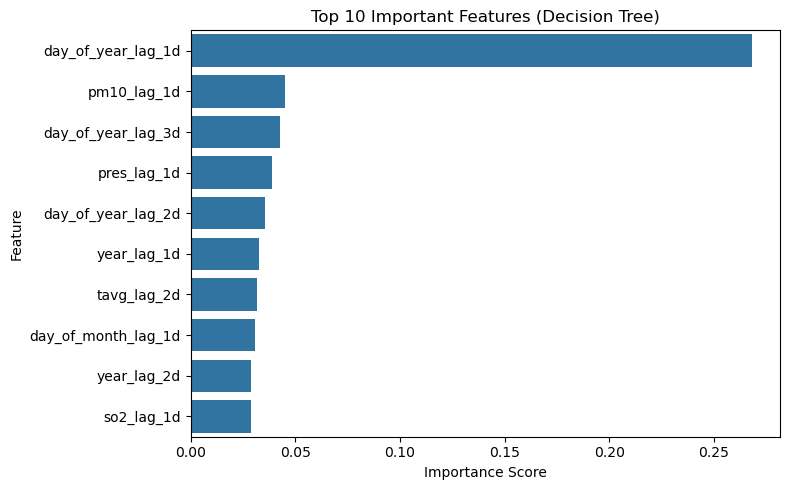

In [47]:
importances = dt_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Decision Tree:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

### Random Forest

In [48]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [49]:
y_pred = rf_regressor.predict(X_flat_test)

In [50]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.4913
  MSE: 0.4140
  RMSE: 0.6434
  R2 Score: 0.2710
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.4719
  MSE: 0.3710
  RMSE: 0.6091
  R2 Score: 0.0509
--------------------
Metrics for Output 3 (no2):
  MAE: 0.4086
  MSE: 0.2839
  RMSE: 0.5328
  R2 Score: -0.0426
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5156
  MSE: 0.3488
  RMSE: 0.5906
  R2 Score: -0.2001
--------------------
Metrics for Output 5 (co):
  MAE: 0.9910
  MSE: 1.0541
  RMSE: 1.0267
  R2 Score: -17.4521
--------------------
Metrics for Output 6 (year):
  MAE: 1.5747
  MSE: 2.5959
  RMSE: 1.6112
  R2 Score: -3290730603100963739965845405696.0000
--------------------
Metrics for Output 7 (month):
  MAE: 0.0804
  MSE: 0.0100
  RMSE: 0.0999
  R2 Score: 0.9197
--------------------
Metrics for Output 8 (day_of_month):
  MAE: 0.4983
  MSE: 0.4495
  RMSE: 0.6704
  R2 Score: 0.5370
--------------------
Metrics for Output 9 (day_of_week):
  MAE: 0.7272
  MSE: 

Top 10 important features for Random Forest:
day_of_year_lag_1d: 0.2251
day_of_year_lag_2d: 0.0574
day_of_year_lag_3d: 0.0497
pm10_lag_1d: 0.0449
pres_lag_1d: 0.0362
day_of_month_lag_1d: 0.0350
tmax_lag_1d: 0.0271
so2_lag_1d: 0.0236
tavg_lag_1d: 0.0223
tmax_lag_2d: 0.0193


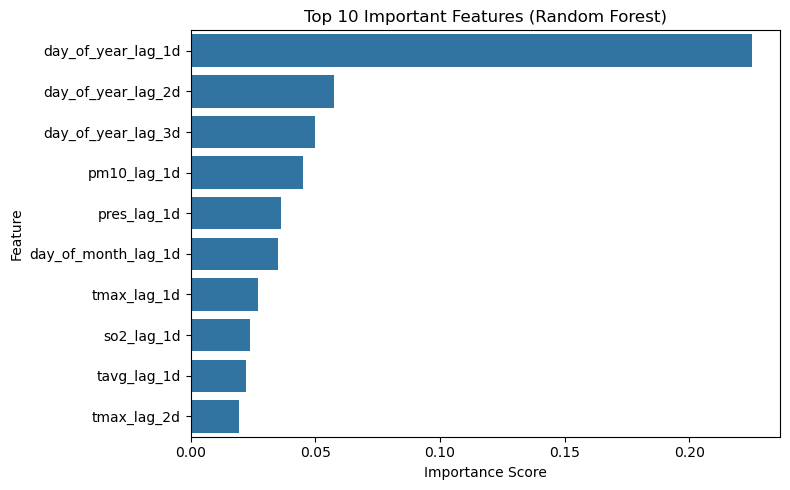

In [51]:
importances = rf_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Random Forest:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [52]:
base_regressor = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

multi_regressor = MultiOutputRegressor(base_regressor)
multi_regressor.fit(X_flat_train, y_flat_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [53]:
y_pred = multi_regressor.predict(X_flat_test)
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.2718
  MSE: 0.1726
  RMSE: 0.4154
  R2 Score: 0.6961
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.4105
  MSE: 0.2788
  RMSE: 0.5280
  R2 Score: 0.2868
--------------------
Metrics for Output 3 (no2):
  MAE: 0.3660
  MSE: 0.2131
  RMSE: 0.4617
  R2 Score: 0.2172
--------------------
Metrics for Output 4 (so2):
  MAE: 0.2649
  MSE: 0.1248
  RMSE: 0.3533
  R2 Score: 0.5706
--------------------
Metrics for Output 5 (co):
  MAE: 0.5297
  MSE: 0.3268
  RMSE: 0.5717
  R2 Score: -4.7208
--------------------
Metrics for Output 6 (year):
  MAE: 1.1312
  MSE: 1.2796
  RMSE: 1.1312
  R2 Score: -1622083314512637119765210464256.0000
--------------------
Metrics for Output 7 (month):
  MAE: 0.0076
  MSE: 0.0004
  RMSE: 0.0197
  R2 Score: 0.9969
--------------------
Metrics for Output 8 (day_of_month):
  MAE: 0.0891
  MSE: 0.1389
  RMSE: 0.3727
  R2 Score: 0.8569
--------------------
Metrics for Output 9 (day_of_week):
  MAE: 0.0000
  MSE: 0.0

In [54]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(merged_df.columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2854
 2. pm25_lag_1d          : 0.2368
 3. no2_lag_1d           : 0.0753
 4. tmax_lag_1d          : 0.0266
 5. month_lag_2d         : 0.0234
 6. month_lag_1d         : 0.0219
 7. pres_lag_1d          : 0.0174
 8. wspd_lag_1d          : 0.0164
 9. tmax_lag_2d          : 0.0144
10. day_of_year_lag_1d   : 0.0140

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1222
 2. pm25_lag_1d          : 0.0463
 3. pm10_lag_2d          : 0.0432
 4. no2_lag_1d           : 0.0417
 5. pres_lag_1d          : 0.0319
 6. day_of_year_lag_2d   : 0.0258
 7. pm25_lag_2d          : 0.0257
 8. day_of_week_lag_1d   : 0.0248
 9. day_of_year_lag_1d   : 0.0237
10. day_of_week_lag_3d   : 0.0218

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.2179
 2. tavg_lag_1d          : 0.0918
 3. is_working_day_lag_2d : 0.0432
 4. day_of_year_lag_1d   : 0.0313
 5. tmin_lag_1d          : 0.0297
 6. tmin_lag_2d          : 0.0270
 7. day_of_year_lag_2d   : 0.0263
 8. tav

### Neural Networks

In [55]:
class EarlyStopping:
    """Early stopping utility to monitor validation loss and save best weights"""

    def __init__(self, patience=10, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights

        self.best_loss = float("inf")
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss improved
            self.best_loss = val_loss
            self.counter = 0
            # Save best weights
            if self.restore_best_weights:
                self.best_weights = {
                    k: v.clone().detach() for k, v in model.state_dict().items()
                }
        else:
            # No improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def restore_best_weights_to_model(self, model):
        """Restore the best weights to the model"""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)
            print(f"Restored best weights (val_loss: {self.best_loss:.6f})")

In [56]:
# Prepare data for LSTM: convert windowed data to tensors
def windows_to_tensor(X_windows, y_windows):
    # X: list of DataFrames, each (window_size, num_features)
    # y: list of DataFrames, each (prediction_window_size, num_targets)
    X_tensor = torch.tensor(
        np.stack([x.values for x in X_windows]), dtype=torch.float32
    )
    y_tensor = torch.tensor(
        np.stack([y.values for y in y_windows]), dtype=torch.float32
    )
    return X_tensor, y_tensor

In [57]:
X_lstm_train, y_lstm_train = windows_to_tensor(X_window_train, y_window_train)
X_lstm_val, y_lstm_val = windows_to_tensor(X_window_val, y_window_val)
X_lstm_test, y_lstm_test = windows_to_tensor(X_window_test, y_window_test)

In [58]:
X_lstm_train.shape

torch.Size([1035, 3, 22])

In [59]:
y_lstm_train.shape

torch.Size([1035, 3, 22])

In [60]:
class LSTMRegressor(nn.Module):

    def __init__(
        self, input_dim, hidden_dim, output_dim, num_layers=1, prediction_window_size=3
    ):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim * prediction_window_size)
        
        self.output_dim = output_dim
        self.prediction_window_size = prediction_window_size

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Use last hidden state for prediction
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.fc(out)
        # Reshape to (batch, prediction_window_size, output_dim)
        out = out.view(-1, self.prediction_window_size, self.output_dim)
        return out

In [61]:
input_dim = X_lstm_train.shape[2]
output_dim = y_lstm_train.shape[2]
hidden_dim = 64
num_layers = 2
prediction_window_size = y_lstm_train.shape[1]

model = LSTMRegressor(
    input_dim, hidden_dim, output_dim, num_layers, prediction_window_size
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=15, min_delta=1e-6)

# Training loop
epochs = 100
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_lstm_train.size(0))
    epoch_loss = 0
    for i in range(0, X_lstm_train.size(0), batch_size):
        idx = permutation[i : i + batch_size]
        batch_X, batch_y = X_lstm_train[idx], y_lstm_train[idx]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= X_lstm_train.size(0)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_lstm_val)
        val_loss = criterion(val_output, y_lstm_val).item()
    
    # Print progress
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Best Val: {early_stopping.best_loss:.6f}"
    )
    
    # Early stopping check
    if early_stopping(val_loss, model):
        best_epoch = epoch + 1 - early_stopping.patience
        print(f"\nEarly stopping triggered at epoch {epoch + 1}")
        print(f"Best epoch was {best_epoch} with val_loss: {early_stopping.best_loss:.6f}")
        break

    # Update best epoch if this is the best so far
    if val_loss == early_stopping.best_loss:
        best_epoch = epoch + 1

# Restore best weights
early_stopping.restore_best_weights_to_model(model)

# Training completed
final_status = "Early stopped" if early_stopping.early_stop else "Completed"
print(f"\nTraining {final_status.lower()} after {epoch + 1} epochs")
print(f"Best validation loss: {early_stopping.best_loss:.6f} at epoch {best_epoch}")

Epoch 1/100 | Train Loss: 1.0064 | Val Loss: 1.1965 | Best Val: inf
Epoch 2/100 | Train Loss: 0.7789 | Val Loss: 1.0237 | Best Val: 1.196534
Epoch 3/100 | Train Loss: 0.6919 | Val Loss: 0.8084 | Best Val: 1.023681
Epoch 4/100 | Train Loss: 0.6372 | Val Loss: 0.6959 | Best Val: 0.808429
Epoch 5/100 | Train Loss: 0.6063 | Val Loss: 0.6377 | Best Val: 0.695889
Epoch 6/100 | Train Loss: 0.5746 | Val Loss: 0.6074 | Best Val: 0.637717
Epoch 7/100 | Train Loss: 0.5536 | Val Loss: 0.5950 | Best Val: 0.607372
Epoch 8/100 | Train Loss: 0.5401 | Val Loss: 0.5881 | Best Val: 0.594951
Epoch 9/100 | Train Loss: 0.5213 | Val Loss: 0.5958 | Best Val: 0.588076
Epoch 10/100 | Train Loss: 0.5097 | Val Loss: 0.5898 | Best Val: 0.588076
Epoch 11/100 | Train Loss: 0.4969 | Val Loss: 0.5757 | Best Val: 0.588076
Epoch 12/100 | Train Loss: 0.4905 | Val Loss: 0.5791 | Best Val: 0.575686
Epoch 13/100 | Train Loss: 0.4863 | Val Loss: 0.5827 | Best Val: 0.575686
Epoch 14/100 | Train Loss: 0.4766 | Val Loss: 0.5719

In [62]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_lstm_test).cpu().numpy()
    y_true_lstm = y_lstm_test.cpu().numpy()

# Flatten for metric calculation (same as previous evaluate_predictions)
y_pred_flat = y_pred_lstm.reshape(y_pred_lstm.shape[0], -1)
y_true_flat = y_true_lstm.reshape(y_true_lstm.shape[0], -1)

evaluate_predictions(
    y_true=y_true_flat, y_pred=y_pred_flat, window_size=prediction_window_size
)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.3719
  MSE: 0.2688
  RMSE: 0.5185
  R2 Score: 0.5266
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.4143
  MSE: 0.2676
  RMSE: 0.5173
  R2 Score: 0.3155
--------------------
Metrics for Output 3 (no2):
  MAE: 0.3590
  MSE: 0.2079
  RMSE: 0.4560
  R2 Score: 0.2366
--------------------
Metrics for Output 4 (so2):
  MAE: 0.2915
  MSE: 0.1648
  RMSE: 0.4059
  R2 Score: 0.4330
--------------------
Metrics for Output 5 (co):
  MAE: 0.5254
  MSE: 0.3104
  RMSE: 0.5572
  R2 Score: -4.4342
--------------------
Metrics for Output 6 (year):
  MAE: 0.6991
  MSE: 0.4997
  RMSE: 0.7069
  R2 Score: -8791677468672.0000
--------------------
Metrics for Output 7 (month):
  MAE: 0.0626
  MSE: 0.0072
  RMSE: 0.0847
  R2 Score: 0.9422
--------------------
Metrics for Output 8 (day_of_month):
  MAE: 0.4902
  MSE: 0.4738
  RMSE: 0.6883
  R2 Score: 0.5119
--------------------
Metrics for Output 9 (day_of_week):
  MAE: 0.6794
  MSE: 0.6715
  RMSE: 0.8195

## Real world prediction

In [63]:
X = merged_df[-historical_window_size:]
X[numerical_features] = scaler.transform(X[numerical_features])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
X.shape

(3, 22)

In [68]:
# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X[numerical_features] = scaler.transform(X[numerical_features])

for day in range(num_of_predictions):
    # Input expects multiple windows
    X_flat = flatten_windows([X])

    y_pred = multi_regressor.predict(X_flat)

    # Split y_pred into 3 arrays, one for each prediction day
    y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

    # Create DataFrame for predictions, each row is a prediction day
    predictions_df = pd.DataFrame(y_pred_split, columns=merged_df.columns)

    # Set the index to continue from the last date in merged_df
    last_date = X.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
    predictions_df.index = future_dates

    # Add predictions to the end so that we can use them as input (don't forget to remove the same number of items as we added - model expects certain size)
    X = pd.concat([X[prediction_window_size:], predictions_df], axis=0)

X[numerical_features] = scaler.inverse_transform(X[numerical_features])

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
iaqi_features = ["pm25", "pm10", "no2", "so2", "co"]
X["aqi"] = X[iaqi_features].max(axis=1)

print(X[-num_of_predictions*prediction_window_size:][iaqi_features])

                 pm25       pm10       no2       so2        co
2025-07-19  24.363049  23.131334  7.063460  5.296374  3.056344
2025-07-20  47.625214  25.676804  6.985757  3.326472  2.979872
2025-07-21  55.319256  18.901415  7.255639  2.395222  4.386737


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
